<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Convolutions/Semantic_segmentation_dermoscopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic segmentation

In [1]:
%%capture
!pip install wandb

## imports

In [2]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import wandb

from google.colab import userdata
from matplotlib import rcParams
from skimage.io import imread
from skimage.transform import resize
from time import time
from torch.utils.data import DataLoader
from torchvision import models
from typing import Callable, List, Dict, Tuple

from IPython.display import clear_output

In [3]:
rcParams['figure.figsize'] = (15,4)

## Download and unzip dataset

In [4]:
%%capture
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

In [5]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [6]:
images = []
lesions = []

for root, dirs, files in os.walk(os.path.join('PH2Dataset', 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

## Set config

In [7]:
class CFG:
  batch_size = 16
  out_channels = 64
  batch_norm_momentum = 0.1
  seed = 42
  device = lambda: torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  loss = lambda: 'dice'
  lr = 3e-4
  epochs=1
  wandbapi = False

wandb_config = lambda: {
    'achitecture':'SegNet',
    'activation':'relu',
    'optimizer':'AdamW',
    'lr':CFG.lr,
    'lr_scheduler_step': 5,
    'loss': CFG.loss(),
    'batch_size':CFG.batch_size,
    'device':CFG.device(),
}

In [8]:
try:
    CFG.wandbapi = userdata.get('wandb')
    project="Semantic_segmentation_dermoscopic"
    entity='dimildizio'
    wandb.login(key=CFG.wandbapi)

except Exception as e:
  print(e)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
def wandb_wrapper(func: Callable) -> Callable:
    """
    A wrapper function for integrating with Weights & Biases (wandb).

    Args:
        func (Callable): The function to be wrapped.

    Returns:
        Callable: The wrapped function.
    """
    def wrapped_function(*args, **kwargs):
        print('wrapper works')
        if CFG.wandbapi:
            wandb.init(project=project, entity=entity, config=wandb_config())
            print('Logging wandb')
        try:
          result = func(*args, **kwargs)
        except Exception as e:
          if CFG.wandbapi:
            wandb.log({"error_message": str(e)}, commit=False)
            wandb.finish()
          raise e
        finally:
          if CFG.wandbapi:
            wandb.finish()
        return result
    return wrapped_function

### Freeze seeds

In [10]:
def seed_everything(seed: int=CFG.seed) -> None:
  np.random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

In [11]:
def seed_wrapper(func: Callable) -> Callable:
    """
    A wrapper function for repeatability and reproducibility.

    Args:
        func (Callable): The function to be wrapped.

    Returns:
        Callable: The wrapped function.
    """
    def wrapped_function(*args, **kwargs):
        seed_everything()
        result = func(*args, **kwargs)
        return result
    return wrapped_function

In [12]:
seed_everything()

## Dataset

### Resize and transform

In [13]:
size = (256, 256)
X = np.array([resize(x, size, mode='constant', anti_aliasing=True,) for x in images], np.float32)
Y = np.array([resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions], np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


### Preview images

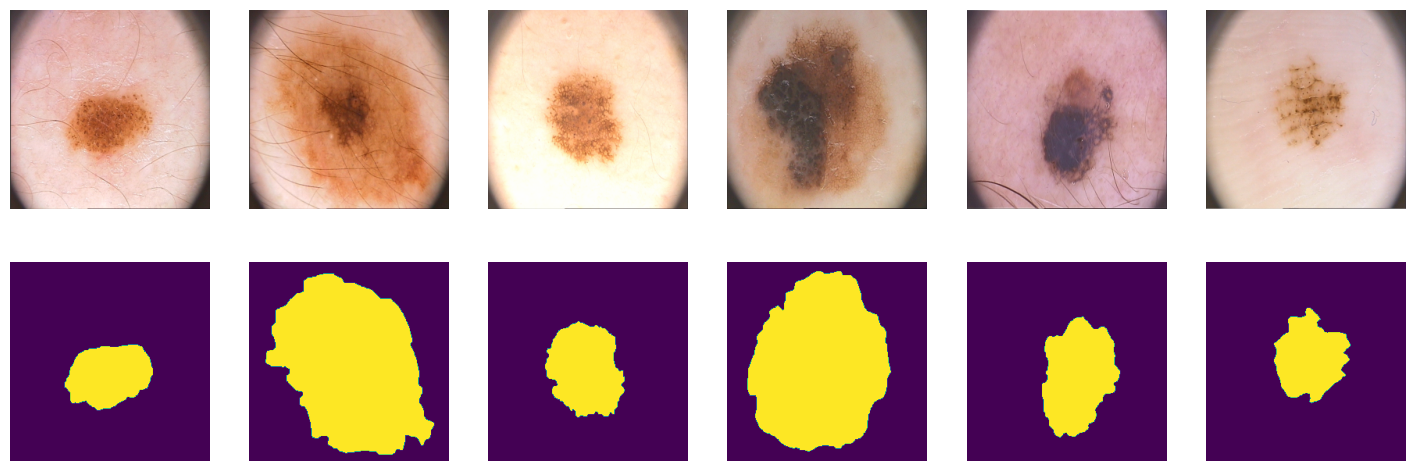

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show()

Split indexes

In [14]:
@seed_wrapper
def tvt_split_custom(X):
  idx = np.random.choice(len(X), len(X), False)
  return np.split(idx, [100, 150])

In [15]:
train, val, test = tvt_split_custom(X)

### Create dataloaders

In [16]:
def match_idxs(idx: np.ndarray, xs: np.ndarray = X, ys: np.ndarray = Y) -> list:
    """
    Match indices and create a list of tuples.

    Parameters:
    - idx: np.ndarray
        An array of indices.
    - xs: np.ndarray, optional
        The input array for x (default value X).
    - ys: np.ndarray, optional
        The input array for y (default value Y).

    Returns:
    - list
        A list of tuples created by matching indices.
    """
    x = np.moveaxis(xs[idx], source=3, destination=1)
    y = ys[idx, np.newaxis]
    new_array = list(zip(x, y))
    return new_array

In [18]:
data_train = DataLoader(match_idxs(train), batch_size=CFG.batch_size, shuffle=True)
data_val = DataLoader(match_idxs(val), batch_size=CFG.batch_size, shuffle=True)
data_test = DataLoader(match_idxs(test), batch_size=CFG.batch_size, shuffle=False)


## SegNet

![picture](https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/Convolutions/data/segnet_pic.png)
----------------------------------------------------------------------------------------


* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [17]:
class SegNet(nn.Module):
    def __init__(self, inch=3):
        super().__init__()

        # encoder (downsampling)
        # down_0
        ouch_0 = CFG.out_channels
        self.encoder_conv_0 = nn.Sequential(
            nn.Conv2d(in_channels=inch, out_channels=ouch_0, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_0, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_0, out_channels=ouch_0, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_0, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            )

        self.pool_0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128

        # down_1
        ouch_1 = ouch_0 * 2
        self.encoder_conv_1 = nn.Sequential(
            nn.Conv2d(in_channels=ouch_0, out_channels=ouch_1, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_1, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_1, out_channels=ouch_1, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_1, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
        )
        self.pool_1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        # down_2
        ouch_2 = ouch_1 * 2
        self.encoder_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=ouch_1, out_channels=ouch_2, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_2, out_channels=ouch_2, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_2, out_channels=ouch_2, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )
        self.pool_2 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        # down_3
        ouch_3=ouch_2 * 2
        self.encoder_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=ouch_2, out_channels=ouch_3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )
        self.pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
          nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )

        self.bottleneck_pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.bottleneck_upsample = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.bottleneck_decoder =  nn.Sequential(
          nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                    kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                      kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                      kernel_size=3, padding=(1,1)),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )

        # decoder (upsampling)
        # up_1
        self.upsample_0 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.decoder_conv_0 = nn.Sequential(
          nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_3,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_3, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_3, out_channels=ouch_2,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )

        # up_2
        self.upsample_1 =  nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.decoder_conv_1 = nn.Sequential(
          nn.Conv2d(in_channels=ouch_2, out_channels=ouch_2,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_2, out_channels=ouch_2,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_2, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_2, out_channels=ouch_1,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_1, momentum=CFG.batch_norm_momentum),
            nn.ReLU()
        )

        # up_3
        self.upsample_2 =  nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.decoder_conv_2 = nn.Sequential(
          nn.Conv2d(in_channels=ouch_1, out_channels=ouch_1,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_1, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_1, out_channels=ouch_0,
                      kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_0, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
          )

        # up_4
        self.upsample_3 =  nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.decoder_conv_3 =nn.Sequential(
          nn.Conv2d(in_channels=ouch_0, out_channels=ouch_0,
                    kernel_size=3, padding=1),
            nn.BatchNorm2d(ouch_0, momentum=CFG.batch_norm_momentum),
            nn.ReLU(),
            nn.Conv2d(in_channels=ouch_0, out_channels=1,
                      kernel_size=3, padding=1)
          ) # no activation


    def forward(self, x):
        # encoder
        e_0, idx_0 = self.pool_0(self.encoder_conv_0(x))
        e_1, idx_1 = self.pool_1(self.encoder_conv_1(e_0))
        e_2, idx_2 = self.pool_2(self.encoder_conv_2(e_1))
        e_3, idx_3 = self.pool_3(self.encoder_conv_3(e_2))

        # bottleneck
        b_e, idx_b = self.bottleneck_pool(self.bottleneck_conv(e_3))
        b_d = self.bottleneck_decoder(self.bottleneck_upsample(b_e, idx_b))

        # decoder
        d_0 = self.decoder_conv_0(self.upsample_0(b_d, idx_3))
        d_1 = self.decoder_conv_1(self.upsample_1(d_0, idx_2))
        d_2 = self.decoder_conv_2(self.upsample_2(d_1, idx_1))
        d_3 = self.decoder_conv_3(self.upsample_3(d_2, idx_0))
        return d_3

In [19]:
print(summary(SegNet(), (3, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14  [[

## Metrics

Here we utilize IoU metrics:


$$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$$

So, for example is we have two matrices:

real (y):

         0  1  2
      0 [1, 0, 0]
      1 [0, 1, 0]
      2 [0, 0, 1]

predicted ($\hat{y}$):

        0  1  2
     0 [1, 1, 0]
     1 [0, 1, 0]
     2 [0, 1, 0]

our intersection of ones(!) would look like that, so the sum is **2**:


        0  1  2
     0 [1, 0, 0]
     1 [0, 1, 0]
     2 [0, 0, 0]


and the union would be the sum of all unique places where there are ones at positions, so the result is **5**:

        0  1  2
     0 [1, 1, 0]
     1 [0, 1, 0]
     2 [0, 1, 1]

and in the end we get $$IoU=\frac{ y \cap \hat{y}}{y \cup \hat{y}} = \frac{2}{5}$$

Let's say we got the real values and the prediction:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)

Then the intersection and union should be:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

#### Implementing IoU

In [20]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape

    outputs = torch.sigmoid(outputs) >= 0.5 #  sigmoid(outputs) - lets use torch since its always better optimized
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    #thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return iou.mean().item()  #

## BCE Loss

The common equation for BCE loss is: $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$


In [21]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

def standard_torch_bce_loss(y_hat, y):
  # torch.nn.functional for comparison
  loss = nn.functional.binary_cross_entropy_with_logits(y_hat, y.float())
  return loss

def standard_bce_loss(y_hat, y, epsilon=1e-10):
    # Standard Binary Cross-Entropy Loss
    y_hat = sigmoid(y_hat) + epsilon
    loss = -torch.mean(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))
    return loss


# Example usage:
y_hat = torch.tensor([1.5, 1.5, 2.5])
y = torch.tensor([0, 1, 0], dtype=torch.float32)


print("Standard BCE Loss (Torch):", standard_torch_bce_loss(y_hat, y))
print("Standard BCE Loss (Custom):", standard_bce_loss(y_hat, y))

Standard BCE Loss (Torch): tensor(1.4939)
Standard BCE Loss (Custom): tensor(1.4939)


Due to logarithm of number below 1 and to how sigmoid for probability works: $$\frac{1}{1+\exp(-x)}$$  

One over exponent of very large logits (regardless if negative or postive) results in numerical instability

In [22]:
def check_bce(func, func_name):
  print(f"{func_name}:")
  for nums in ((-1000.0, -1000.0, -2000.0), (1000.0, 1000.0, 2000.0)):
    y_hat_large = torch.tensor([nums[0], nums[1], nums[2]]) # would be the same for negative numbers
    y_large = torch.tensor([0, 1, 1])
    sign = 'positive' if sum(nums) > 0 else 'negative'
    print(f'\tLarge {sign} numbers: {func(y_hat_large, y_large)}')
  print()

In [23]:
check_bce(standard_torch_bce_loss, "Standard BCE Loss (Torch)")
check_bce(standard_bce_loss, "Standard BCE Loss (Custom)")

Standard BCE Loss (Torch):
	Large negative numbers: 1000.0
	Large positive numbers: 333.3333435058594

Standard BCE Loss (Custom):
	Large negative numbers: 15.350566864013672
	Large positive numbers: nan



As it's shown above custom loss cannot deal with numerical instability well and adding a small (1e-10) number epsilon doesn't help (without it the result on large negative numbers would be nan as well).

#### Log-sum-exp trick

To introduce numerical stability we rely on the fact that exp(x) gorws rapidly, and performing the opposite operation - taking logarithm would help avoid under- or over-flow. $$log(1+exp(- |\hat y|)) $$

Then we perform element-wise $max(\hat y , 0)$ which makes them all non-negative values to avoid said num.instability since *log of negative number is undefined*.

We also create $α$ which is $max(\hat y , 0)$ above serving as **margin**( that states that the model is not penalized if the prediction is beyond those values) and $\hat y \cdot y$ - element-wise multiplication of prediction by real values. If they have the same sign - prediction would  be positive, othewise - negative (error) and the model will be penalized by the **margin** size. $$max(\hat y , 0) - \hat y \cdot y$$


So gathering it together we get:  $$\mathcal L_{BCE}(y, \hat y) = max(\hat y , 0) - \hat y \cdot y + log(1+exp(- |\hat y|)) $$

In [26]:
def num_stab_bce_loss(y_hat, y):
    # Numerical stability using log-sum-exp trick
    max_val = torch.max(y_hat, torch.tensor(0.0))
    loss = torch.mean(max_val - y_hat * y + torch.log(1 + torch.exp(-torch.abs(y_hat))))
    return loss

In [27]:
check_bce(standard_torch_bce_loss, "Standard BCE Loss (Torch)")
check_bce(standard_bce_loss, "Standard BCE Loss (Custom)")
check_bce(num_stab_bce_loss, 'Num.Stab BCE Loss (Custom)')

Standard BCE Loss (Torch):
	Large negative numbers: 1000.0
	Large positive numbers: 333.3333435058594

Standard BCE Loss (Custom):
	Large negative numbers: 15.350566864013672
	Large positive numbers: nan

Num.Stab BCE Loss (Custom):
	Large negative numbers: 1000.0
	Large positive numbers: 333.3333435058594



#### Bathe in tests

In [28]:
s1 = torch.randn(10, 3, 256, 256)
s2 = torch.randn(10, 3, 256, 256)

torch_bce_result = nn.BCEWithLogitsLoss()(s1, s2)
custom_bce_result= num_stab_bce_loss(s1, s2)

#round to 1e-6 since the float is a float after all and can get crazy at ~1e-10 values
assert round(torch_bce_result.item(), 6) == round(custom_bce_result.item(), 6)
print(torch_bce_result, custom_bce_result)

tensor(0.8069) tensor(0.8069)


## Training process

In [29]:
@wandb_wrapper
def train(model, optimizer, loss_fn, epochs, train_loader, val_loader, scheduler):
  history = {'train':{'loss':[], 'score':[]},
             'val':{'loss':[], 'score':[]},}

  for epoch in range(epochs):
    tic = time()
    print(f'* Epoch: {epoch+1}/{epochs}')
    avg_train_loss, avg_train_score = train_epoch(model, optimizer,
                                                  loss_fn, train_loader)
    avg_val_loss, avg_val_score = eval_model(model, loss_fn, val_loader,
                                             epoch, epochs)
    history = update_history(history, avg_train_loss, avg_train_score,
                             avg_val_loss, avg_val_score)

    scheduler.step()
    toc = time()

  return history


def train_epoch(model, optimizer, loss_fn, train_loader):

  avg_train_loss = 0
  avg_train_score = 0
  batch=1

  model.train()
  optimizer.zero_grad()

  for X_batch, y_batch in train_loader:
    X_batch = X_batch.to(CFG.device())
    y_batch = y_batch.to(CFG.device())

    y_pred = model.forward(X_batch)

    loss = loss_fn(y_pred, y_batch)
    score = iou_pytorch(y_pred, y_batch)

    loss.backward()
    optimizer.step()

    avg_train_loss += loss/len(train_loader)
    avg_train_score += score/len(train_loader)

    print(f'** batch:{batch}/{len(train_loader)} \
            \n\tloss: {round(avg_train_loss.item(), 4)} \
            \n\tscore: {round(avg_train_score, 4)}\n')
    batch+=1
  return avg_train_loss, avg_train_score


def eval_model(model, loss_fn, val_dataloader, epoch, epochs):
  avg_loss_val = 0
  avg_score_val = 0
  clear_output(wait=True)
  model.eval()

  for X_val, y_val in val_dataloader:
    X_val = X_val.to(CFG.device())
    y_val = y_val.to(CFG.device())

    y_pred = model.forward(X_val).detach().to('cpu')
    loss_val = loss_fn(y_pred, y_val)
    score_val = iou_pytorch(y_pred, y_val)

    avg_loss_val += loss_val / len(val_dataloader)
    avg_score_val += score_val / len(val_dataloader)

    plot_val_pics(X_val, y_val, y_pred, avg_loss_val, avg_score_val, epoch, epochs)

  return avg_loss_val, avg_score_val


def plot_val_pics(X_val, y_val, y_pred, loss_val, score_val, epoch, epochs):
  for k in range(5):
    try:
      plt.subplot(3, 5, k+1)
      plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
      plt.title('Real Input')
      plt.axis('off')

      plt.subplot(3, 5, k+6)
      plt.imshow(y_val[k, 0], cmap='gray')
      plt.title('Real Output')
      plt.axis('off')

      plt.subplot(3, 5, k+11)
      plt.imshow(y_pred[k, 0].numpy(), cmap='gray')
      plt.title('Predicted Output')
      plt.axis('off')
    except IndexError as ie:
      print(ie)
      continue

  plt.suptitle(f'{epoch+1}/{epochs}, val_loss: {loss_val}, val_score: {score_val}')
  plt.show()


def update_history(history, train_loss, train_score, val_loss, val_score):
  log_wandb(train_loss, train_score, val_loss, val_score)
  history['train']['loss'].append(train_loss)
  history['train']['score'].append(train_score)
  history['val']['loss'].append(val_loss)
  history['val']['score'].append(val_score)
  torch.cuda.empty_cache()
  return history


def log_wandb(train_loss, train_score, val_loss, val_score):
  if CFG.wandbapi:
    wandb.log({"Train Loss": train_loss, "Train Score": train_score,
                "Val Loss": val_loss, "Val Score": val_score})

## Inference

In [30]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model.forward(X_batch)  # DO what
        scores += metric(Y_pred, Y_label.to(CFG.device()))
    return scores/len(data)

In [31]:
CFG.epochs = 5
CFG.lr = 4e-4

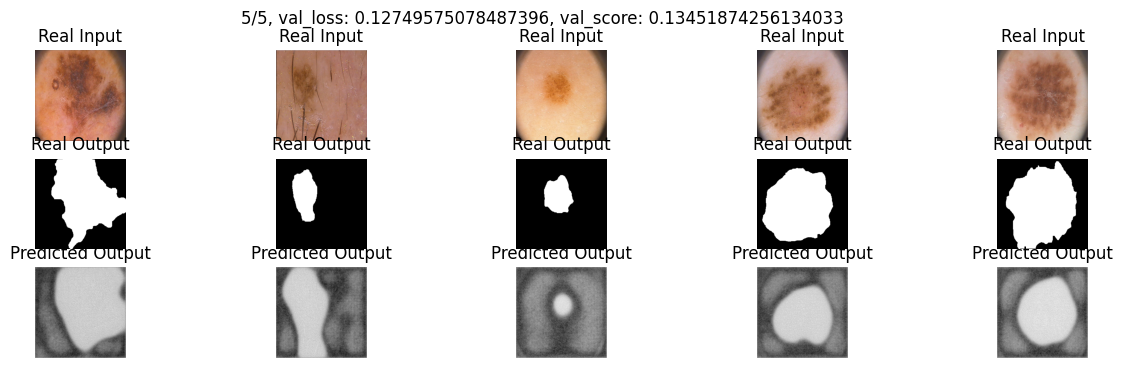

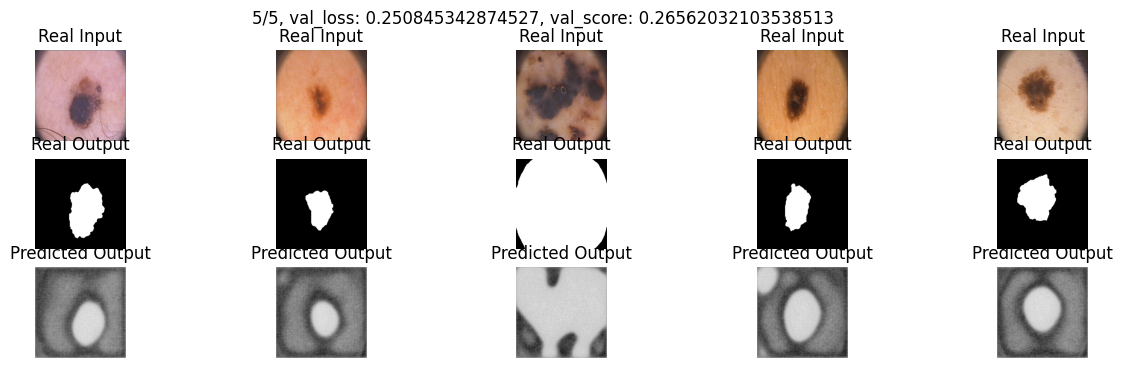

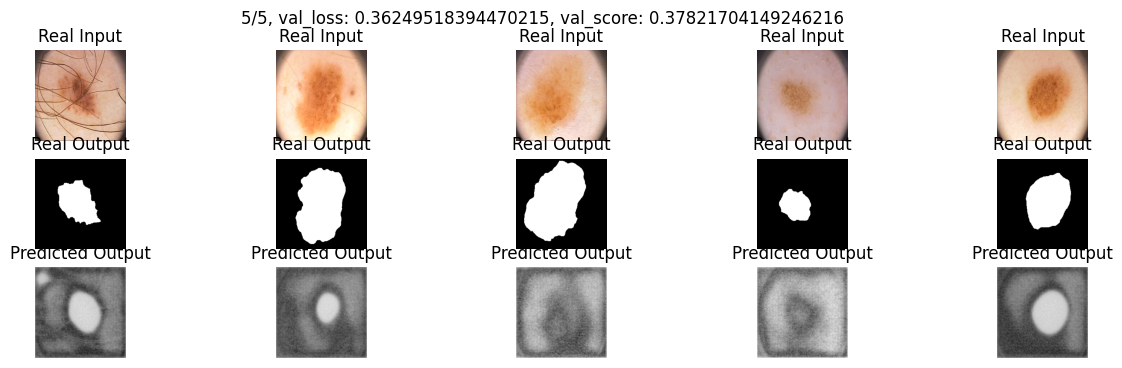

index 2 is out of bounds for dimension 0 with size 2
index 3 is out of bounds for dimension 0 with size 2
index 4 is out of bounds for dimension 0 with size 2


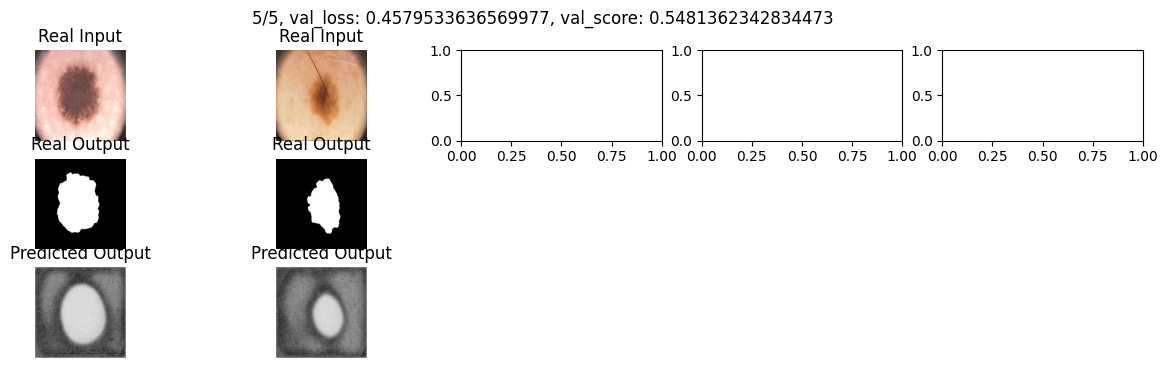

Train Loss,█▆▄▂▁
Train Score,▁▃▆▇█
Val Loss,█▇▅█▁
Val Score,▅▁▁▃█
Train Loss,0.39932
Train Score,0.62155
Val Loss,0.45795
Val Score,0.54814


In [ ]:
model = SegNet().to(CFG.device())
optimizer = torch.optim.AdamW(model.parameters(), lr = CFG.lr, eps=1e-8, weight_decay=1e-6, amsgrad=True)
scheduler =  torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
segnet = train(model, optimizer, num_stab_bce_loss, CFG.epochs, data_train, data_val, scheduler)

In [ ]:
torch.cuda.empty_cache()
del optimizer
del model

## Extra loss functions

### Dice loss

Dice loss is pretty popular for image segmentation when dealing with imbalanced datasets. It's derived from f1-score (or Dice coefficient) which in similar tasks quantifies similarity between sets:

$Coeff_{Dice} = \frac{2\times \text{ Intersection}}{\text{Union } \times { Intersection}}  = \frac {2|\text {X } \cap { \text { Y}|}} {|X|+|Y|}$

As it has been stated above  - **intersection** - is a number of matching pixels in two masks and **union** is a total number of pxls in both masks.

After we find Dice coefficient we calculate loss $$Loss_{dice} = 1 - Coeff_{Dice}$$

#### Implement Dice loss

In [32]:
def dice_loss(predicted, target):
    intersection = torch.sum(predicted * target)
    union = torch.sum(predicted) + torch.sum(target)
    dice_coefficient = (2. * intersection) / (union + intersection)
    dice_coefficient = torch.clamp(dice_coefficient, 0.0, 1.0)
    dice_loss = 1 - dice_coefficient
    return dice_loss

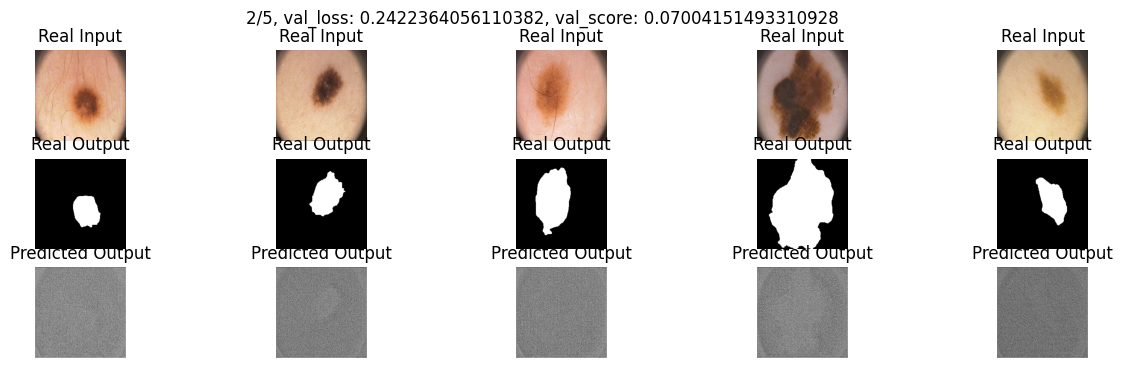

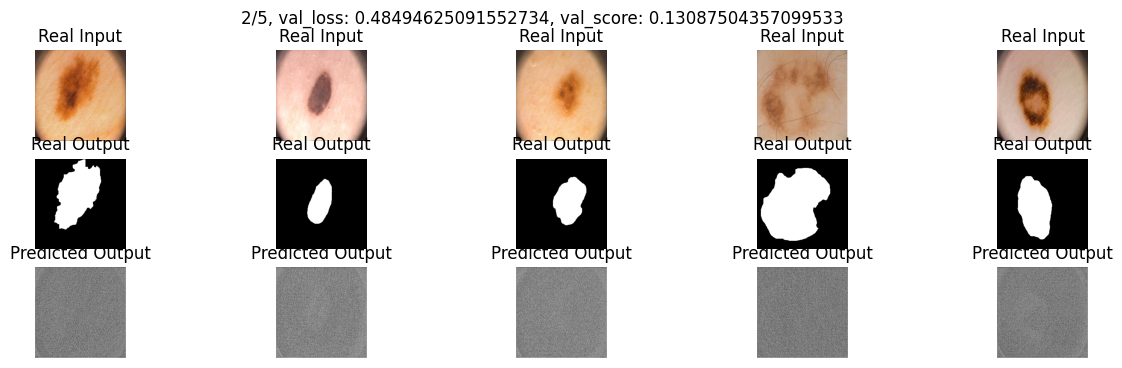

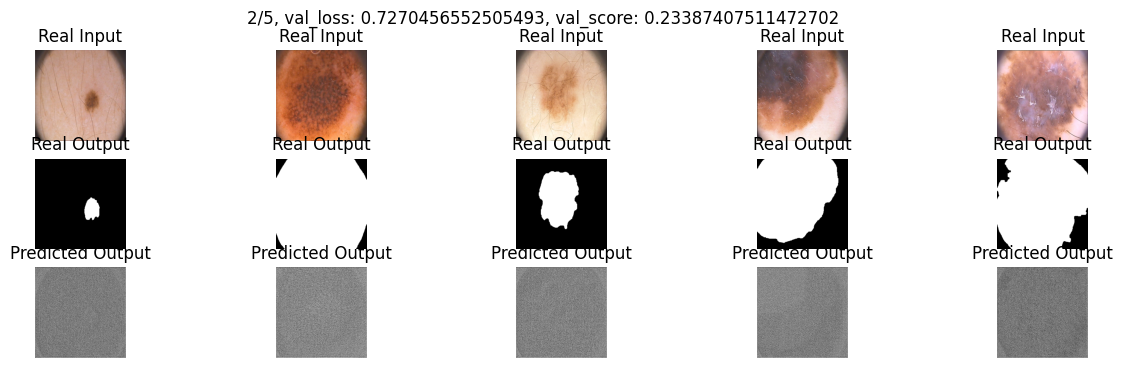

index 2 is out of bounds for dimension 0 with size 2
index 3 is out of bounds for dimension 0 with size 2
index 4 is out of bounds for dimension 0 with size 2


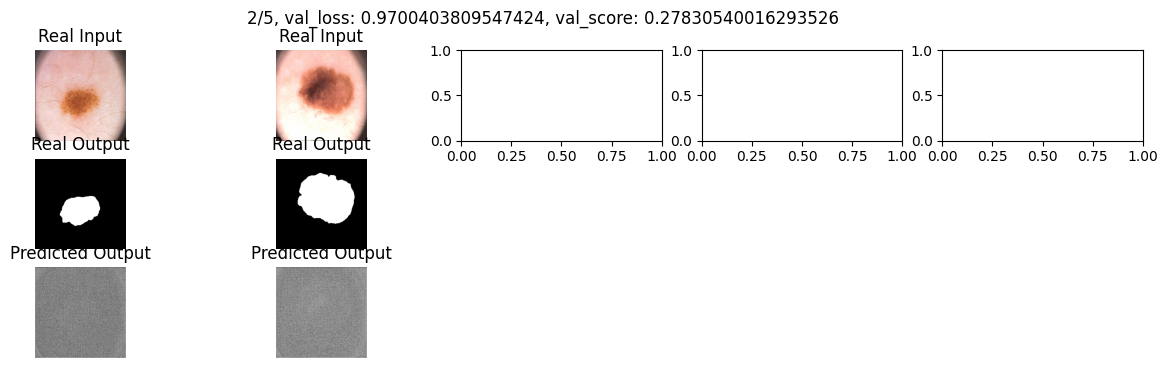

* Epoch: 3/5
** batch:1/7             
	loss: 0.0             
	score: 0.0139

** batch:2/7             
	loss: 0.0             
	score: 0.0311

** batch:3/7             
	loss: 0.1429             
	score: 0.0496

** batch:4/7             
	loss: 0.2857             
	score: 0.0671



In [ ]:
CFG.epochs=5
CFG.loss = 'dice'
model = SegNet().to(CFG.device())
optimizer = torch.optim.AdamW(model.parameters(), lr = CFG.lr, eps=1e-8, weight_decay=1e-6, amsgrad=True)
scheduler =  torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)
segnet = train(model, optimizer, dice_loss, CFG.epochs, data_train, data_val, scheduler)